In [547]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

from tsfeatures import tsfeatures
from tsfeatures import acf_features

from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose 
from datasetsforecast.losses import mae, mape, mase, rmse, smape






from ts_tools.tools import tools
from data_loading_finance.loading_data import LoadingData


In [432]:
df = pd.read_csv("/Users/marcosherediapimienta/Library/Mobile Documents/com~apple~CloudDocs/Documents/Máster de Matemàtiques per els Instruments Financers/TFM/Time_Series/archive/Top10-2021-2024-1d.csv")
df.head()

,Timestamp,BTCUSDT,ETHUSDT,BNBUSDT,SOLUSDT,USDCUSDT,XRPUSDT,DOGEUSDT,ADAUSDT,SHIBUSDT,AVAXUSDT
0,1/1/2021,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69,29331.69
1,1/2/2021,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33,32178.33
2,1/3/2021,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05,33000.05
3,1/4/2021,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71,31988.71
4,1/5/2021,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53,33949.53


In [433]:
# Seleccionar las columnas deseadas del DataFrame original
df_selected = df[['Timestamp', 'BTCUSDT']]
df_selected = df_selected.rename(columns={'Timestamp':'date', 'BTCUSDT': 'BTC'})
df_selected = df_selected.dropna()
print(df_selected)

           date       BTC
0      1/1/2021  29331.69
1      1/2/2021  32178.33
2      1/3/2021  33000.05
3      1/4/2021  31988.71
4      1/5/2021  33949.53
...         ...       ...
1240  5/25/2024  69290.57
1241  5/26/2024  68507.67
1242  5/27/2024  69436.43
1243  5/28/2024  68398.39
1244  5/29/2024  67652.42

[1245 rows x 2 columns]


In [434]:
df_selected["unique_id"]="1"
df_selected.columns=["ds", "y", "unique_id"]
df_selected.head()

,ds,y,unique_id
0,1/1/2021,29331.69,1
1,1/2/2021,32178.33,1
2,1/3/2021,33000.05,1
3,1/4/2021,31988.71,1
4,1/5/2021,33949.53,1


In [435]:
print(df_selected.dtypes)

ds            object
y            float64
unique_id     object
dtype: object


**Apuntes**

En este apartado, hemos verificado rápidamente qué tipo de datos tiene cada columna, lo cual es crucial para asegurar que los datos se estén procesando correctamente y para elegir las operaciones adecuadas a realizar sobre ellos.

object: indica que es una columna de tipo objeto (generalmente significa que contiene cadenas de texto u otros tipos de datos no numéricos).
float64: indica que es una columna de números de punto flotante (números decimales).

In [436]:
df_selected["ds"] = pd.to_datetime(df_selected["ds"])
print(df_selected.dtypes)

ds           datetime64[ns]
y                   float64
unique_id            object
dtype: object


**Apuntes**

En este apartado lo que he hecho es convertir la columna (tipo object) a serie temporal (datetime64[ns]).

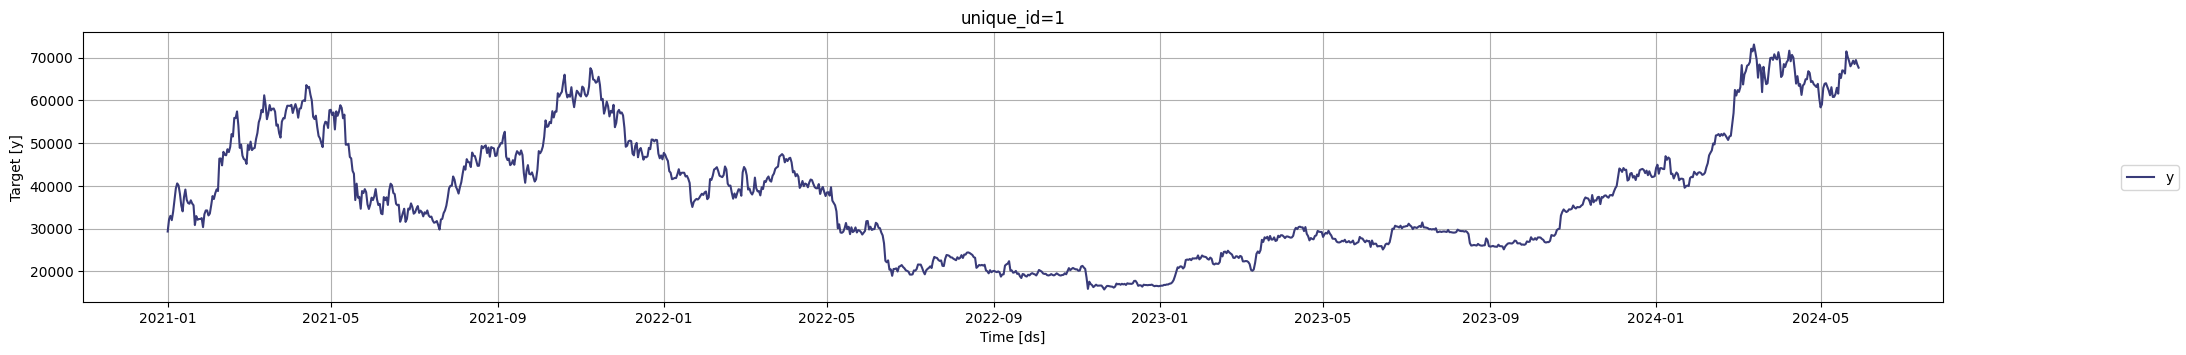

In [437]:
StatsForecast.plot(df_selected, engine="matplotlib")

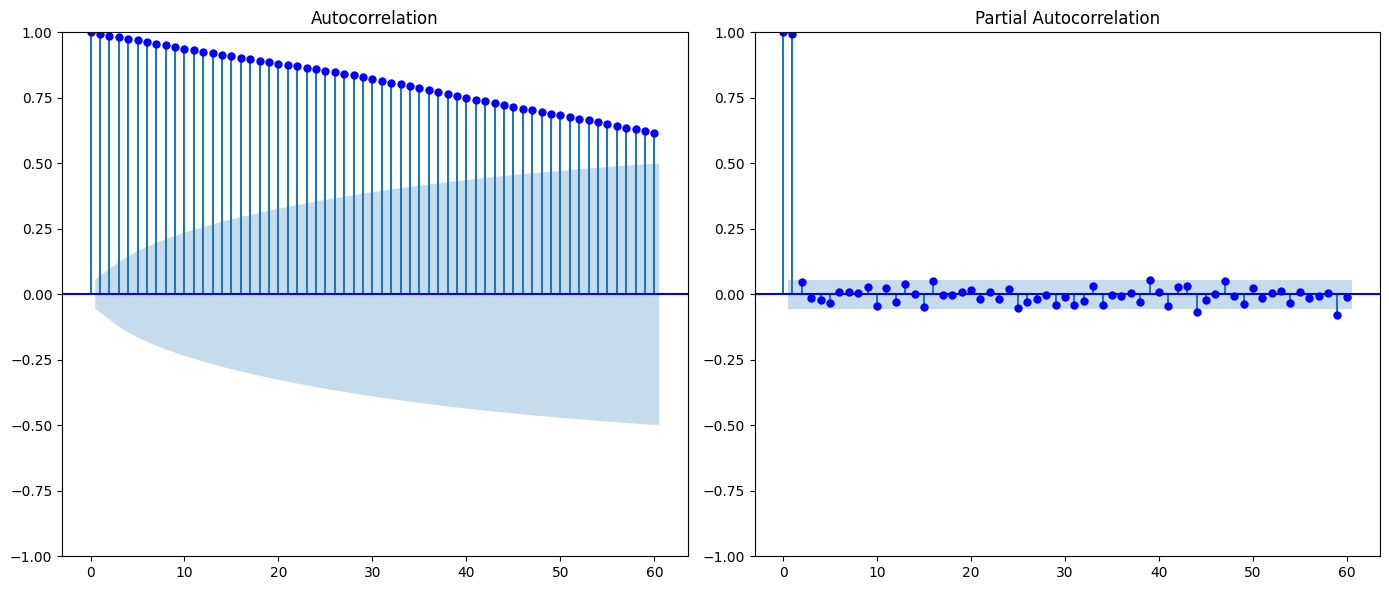

In [438]:
# Crear una figura con dos subgráficos
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Graficar ACF en el primer subgráfico
plot_acf(df_selected["y"], lags=60, ax=axs[0], color="blue")
axs[0].set_title("Autocorrelation")

# Graficar PACF en el segundo subgráfico
plot_pacf(df_selected["y"], lags=60, ax=axs[1], color="blue")
axs[1].set_title('Partial Autocorrelation')

# Ajustar el diseño para que no haya superposición de elementos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

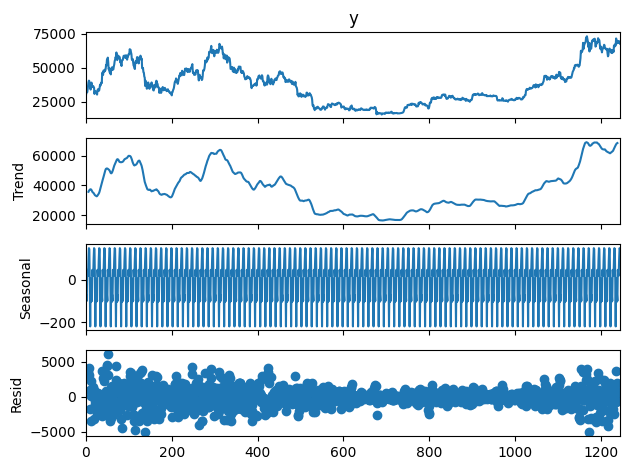

In [439]:
# Descomponer la serie temporal
decomposition = seasonal_decompose(df_selected['y'], model='additive', period=12)
decomposition.plot()
plt.show()

In [440]:
Y_train_df = df_selected[df_selected.ds<='2024-05-01'] 
Y_test_df = df_selected[df_selected.ds>'2024-05-01']
Y_train_df.shape, Y_test_df.shape

((1217, 3), (28, 3))

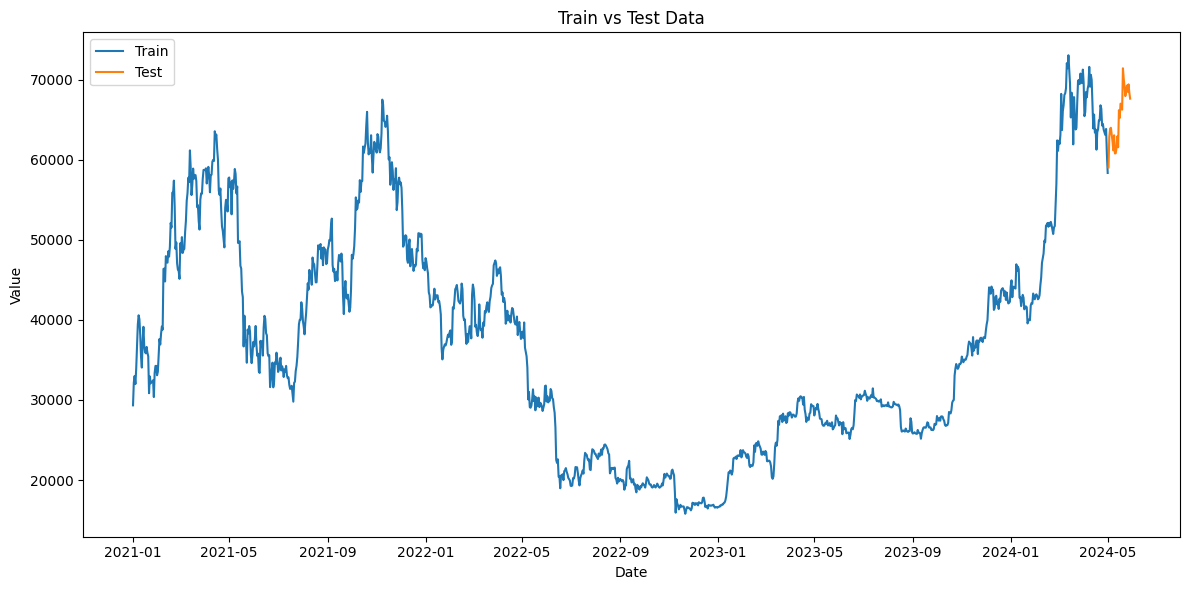

In [441]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 6))

# Graficar las series temporales de entrenamiento y prueba
sns.lineplot(data=Y_train_df, x="ds", y="y", label="Train")
sns.lineplot(data=Y_test_df, x="ds", y="y", label="Test")

# Personalizar etiquetas y título
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Train vs Test Data")
plt.legend()
plt.tight_layout()  
plt.show()


In [476]:
season_length = 12 # Monthly data 
horizon = len(Y_test_df) # number of predictions

models = [AutoARIMA(season_length=season_length)]

In [477]:
sf = StatsForecast(df=Y_train_df,
                   models=models,
                   freq='D', 
                   n_jobs=-1)

In [478]:
sf.fit()

StatsForecast(models=[AutoARIMA])

In [479]:
arima_string(sf.fitted_[0,0].model_)

'ARIMA(1,1,0)(2,0,0)[12]                   '

In [480]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])


dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(1, 0, 2, 0, 12, 1, 0)


In [481]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,29.331675
1,2829.970931
2,1004.583062
3,-953.916880
4,1887.488150
...,...
1212,-491.087535
1213,-506.649612
1214,613.118183
1215,-3092.090947


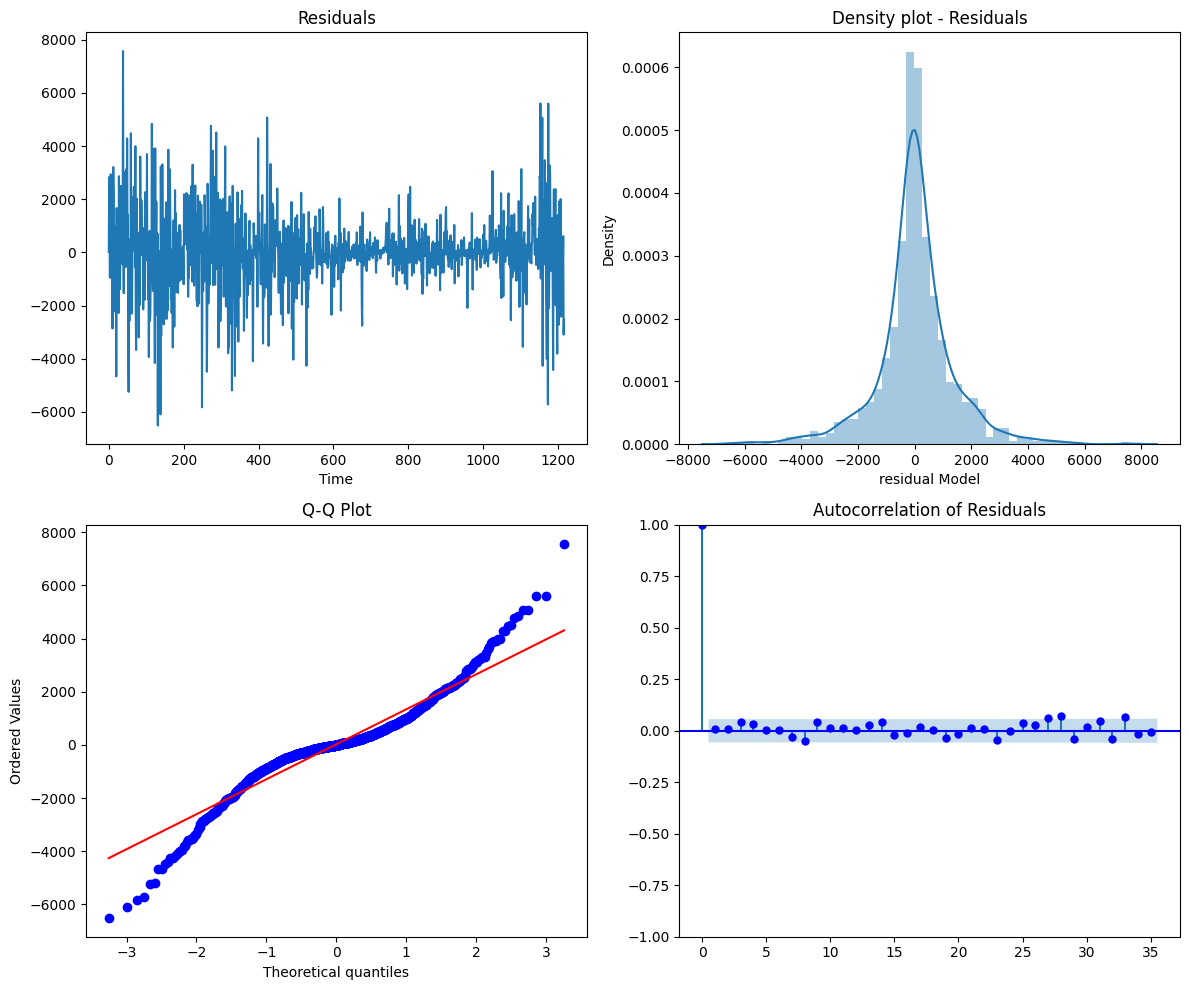

In [482]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Plot de Residuos
residual['residual Model'].plot(ax=axs[0, 0])
axs[0, 0].set_title("Residuals")
axs[0, 0].set_xlabel('Time')

# Density plot - Residuos
sns.distplot(residual['residual Model'], ax=axs[0, 1])
axs[0, 1].set_title("Density plot - Residuals")

# Q-Q Plot de Residuos
stats.probplot(residual['residual Model'], dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Q-Q Plot')

# Autocorrelation de Residuos
plot_acf(residual['residual Model'], lags=35, ax=axs[1, 1], color="blue")
axs[1, 1].set_title("Autocorrelation of Residuals")

plt.tight_layout()
plt.show()


In [525]:
Y_hat_df = sf.forecast(horizon, fitted=True)
Y_hat_df.head()

,ds,AutoARIMA
unique_id,,
1,2024-05-02,58590.480469
1,2024-05-03,58429.542969
1,2024-05-04,58413.492188
1,2024-05-05,58398.480469
1,2024-05-06,58343.550781


In [495]:
forecast_df = sf.forecast(h=28, level = [95]) 
forecast_df

,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
unique_id,,,,
1,2024-05-02,58590.480469,55904.527344,61276.433594
1,2024-05-03,58429.542969,54753.417969,62105.664062
1,2024-05-04,58413.492188,53955.746094,62871.238281
1,2024-05-05,58398.480469,53277.417969,63519.546875
1,2024-05-06,58343.550781,52635.718750,64051.382812
1,2024-05-07,58136.851562,51897.191406,64376.511719
1,2024-05-08,58284.476562,51554.886719,65014.066406
1,2024-05-09,58165.285156,50979.085938,65351.480469
1,2024-05-10,58207.687500,50592.210938,65823.164062


In [504]:
df_plot=pd.concat([df_selected, forecast_df]).set_index('ds').tail(75)
df_plot

,y,unique_id,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
ds,,,,,
2024-04-13,63924.51,1,NaN,NaN,NaN
2024-04-14,65661.84,1,NaN,NaN,NaN
2024-04-15,63419.99,1,NaN,NaN,NaN
2024-04-16,63793.39,1,NaN,NaN,NaN
2024-04-17,61277.37,1,NaN,NaN,NaN
...,...,...,...,...,...
2024-05-25,NaN,NaN,58141.460938,46108.207031,70174.710938
2024-05-26,NaN,NaN,58152.042969,45851.703125,70452.382812
2024-05-27,NaN,NaN,58141.695312,45582.238281,70701.156250


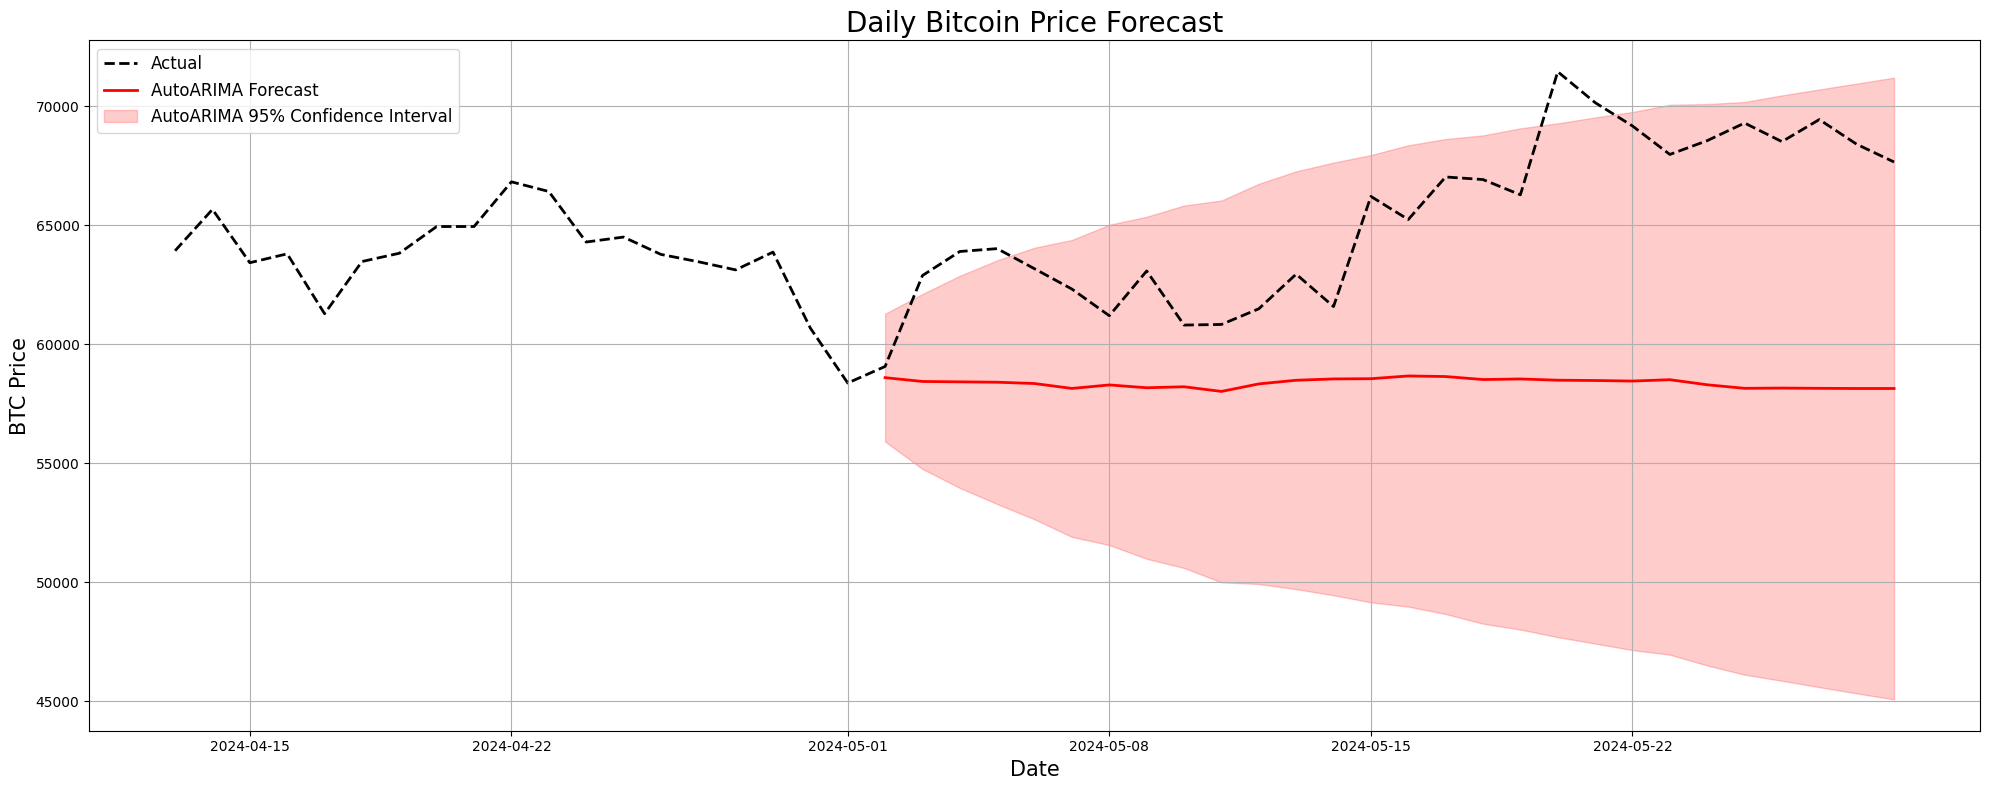

In [505]:
# Asumiendo que df_plot contiene las columnas necesarias y está preparado para trazar

fig, ax = plt.subplots(1, 1, figsize=(20, 8))

# Graficar las series y la predicción
plt.plot(df_plot.index, df_plot['y'], 'k--', label="Actual", linewidth=2)
plt.plot(df_plot.index, df_plot['AutoARIMA'], 'b-', label="AutoARIMA Forecast", linewidth=2, color="red")

ax.fill_between(df_plot.index, 
                df_plot['AutoARIMA-lo-95'], 
                df_plot['AutoARIMA-hi-95'],
                alpha=.2,
                color='red',
                label='AutoARIMA 95% Confidence Interval')

# Configurar título y etiquetas de los ejes
ax.set_title('Daily Bitcoin Price Forecast', fontsize=20)
ax.set_ylabel('BTC Price', fontsize=15)
ax.set_xlabel('Date', fontsize=15)

# Añadir leyenda
ax.legend(prop={'size': 12})

# Mostrar la cuadrícula
ax.grid(True)

# Mostrar el gráfico
plt.tight_layout()
plt.show()



## Validación cruzada

**Apuntes** 

Con los datos de series temporales, la validación cruzada se realiza definiendo una ventana deslizante a través de los datos históricos y prediciendo el período posterior. Esta forma de validación cruzada nos permite llegar a una mejor estimación de las habilidades predictivas de nuestro modelo en una gama más amplia de instancias temporales, al tiempo que mantenemos los datos en el conjunto de entrenamiento contiguos como lo requieren nuestros modelos.

El método cross_validation de la clase StatsForecast toma los siguientes argumentos.

df:marco de datos de entrenamiento

h (int):representa los pasos hacia el futuro que se están pronosticando. En este caso, con 12 meses de antelación.

step_size (int):tamaño de paso entre cada ventana. En otras palabras: ¿con qué frecuencia quieres ejecutar los procesos de previsión?

n_windows(int):número de ventanas utilizadas para la validación cruzada. En otras palabras: ¿qué número de procesos de pronóstico en el pasado quieres evaluar?

El objeto crossvaldation_df es un nuevo marco de datos que incluye las siguientes columnas:

unique_id:índice. Si no te gusta trabajar con el índice, solo tienes que ejecutarcrossvalidation_df.resetindex()

ds:sello de fecha o índice temporal

cutoff:el último sello de fecha o índice temporal para las n_windows.

y:verdadero valor

"model":columnas con el nombre del modelo y el valor ajustado.

In [514]:
crossvalidation_df = sf.cross_validation(df=Y_train_df,
                                         h=12,
                                         step_size=12,
                                         n_windows=5)

In [513]:
crossvalidation_df.tail()

,ds,cutoff,y,AutoARIMA
unique_id,,,,
1,2024-04-27,2024-04-19,63461.980469,63876.617188
1,2024-04-28,2024-04-19,63118.621094,64021.312500
1,2024-04-29,2024-04-19,63866.000000,64124.550781
1,2024-04-30,2024-04-19,60672.000000,64067.164062
1,2024-05-01,2024-04-19,58364.968750,64077.437500


In [515]:
rmse = rmse(crossvalidation_df['y'], crossvalidation_df["AutoARIMA"])
print("RMSE using cross-validation: ", rmse)


RMSE using cross-validation:  4674.5586
